<a href="https://colab.research.google.com/github/Else-If-05/Pomme_ou_Poire/blob/main/CNN_PommePoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf

POUR SUPPRIMER (CLEAR) LES FICHIERS PRESENTS DANS L'ENVIRONNEMENT COLAB

In [4]:
import os
import glob

# Liste tous les fichiers dans /content (pas les sous-dossiers)
files = glob.glob('/content/*')

for f in files:
    try:
        if os.path.isfile(f):
            os.remove(f)  # Supprime le fichier
        elif os.path.isdir(f):
            # Si c'est un dossier, on le supprime aussi (optionnel)
            import shutil
            shutil.rmtree(f)
    except Exception as e:
        print(f"Erreur en supprimant {f} : {e}")

print("Tous les fichiers et dossiers dans /content ont été supprimés.")


Tous les fichiers et dossiers dans /content ont été supprimés.


In [5]:
# Import dataset
import pathlib
import os
import zipfile
import tensorflow as tf

# Télécharger les datasets
pear_data_dir = tf.keras.utils.get_file(
    "pear.zip",
    "https://github.com/Else-If-05/Pomme_ou_Poire/raw/main/datasets/pear.zip",
    extract=False
)

apple_data_dir = tf.keras.utils.get_file(
    "apple.zip",
    "https://github.com/Else-If-05/Pomme_ou_Poire/raw/main/datasets/apple.zip",
    extract=False
)

# Créer le dossier datasets s'il n'existe pas
os.makedirs('/content/datasets', exist_ok=True)

# Dézipper les datasets dans le dossier /content/datasets
with zipfile.ZipFile(pear_data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
with zipfile.ZipFile(apple_data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

# Pointer vers le bon répertoire (à ajuster si le zip crée des sous-dossiers)
data_dir = pathlib.Path('/content/datasets')
print(data_dir)
print(os.path.abspath(data_dir))


12583147/12583147 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
15296016/15296016 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
/content/datasets
/content/datasets


POUR SUPPRIMER 500 IMAGES DU DOSSIER DES POIRES

In [6]:
import os
import random
from pathlib import Path

# Chemin du dossier contenant les poires
dossier_poires = Path("/content/datasets/apple/Apple Red 3")

# Vérification que le dossier existe
if not dossier_poires.exists():
    raise FileNotFoundError(f"Le dossier {dossier_poires} n'existe pas")

# Lister tous les fichiers image (ajuster les extensions si nécessaire)
extensions = ('.jpg', '.jpeg', '.png', '.webp')
fichiers = [f for f in dossier_poires.iterdir() if f.suffix.lower() in extensions]

print(f"Nombre initial d'images : {len(fichiers)}")

# Vérifier qu'il y a assez d'images à supprimer
if len(fichiers) <= 340:
    raise ValueError(f"Il n'y a que {len(fichiers)} images. Impossible d'en supprimer 340")

# Sélection aléatoire de 340 fichiers à supprimer
fichiers_a_supprimer = random.sample(fichiers, 340)

# Journal des suppressions
log_file = dossier_poires.parent / "deletion_log.txt"
with open(log_file, "w") as f:
    f.write("Fichiers supprimés:\n")
    for fichier in fichiers_a_supprimer:
        f.write(f"{fichier.name}\n")

# Suppression effective
for fichier in fichiers_a_supprimer:
    os.remove(fichier)

print(f"500 images ont été supprimées. Journal des suppressions sauvegardé dans {log_file}")
print(f"Nombre restant d'images : {len(fichiers) - 340}")

Nombre initial d'images : 429
500 images ont été supprimées. Journal des suppressions sauvegardé dans /content/datasets/apple/deletion_log.txt
Nombre restant d'images : 89


In [7]:
import pathlib

data_dir = pathlib.Path('/content/datasets')
image_extensions = ['*.jpg', '*.jpeg', '*.png']

# Compter le nombre total d'images
image_count = 0
for ext in image_extensions:
    image_count += len(list(data_dir.rglob(ext)))

print(f"Nombre total d'images : {image_count}")

# Compter les images de poires
pear_data_dir = pathlib.Path('/content/datasets/pear')
pear_image_count = 0
for ext in image_extensions:
    pear_image_count += len(list(pear_data_dir.rglob(ext)))

print(f"Nombre total d'images de poires : {pear_image_count}")

# Compter les images de pommes
apple_data_dir = pathlib.Path('/content/datasets/apple')
apple_image_count = 0
for ext in image_extensions:
    apple_image_count += len(list(apple_data_dir.rglob(ext)))

print(f"Nombre total d'images de pommes : {apple_image_count}")


Nombre total d'images : 5449
Nombre total d'images de poires : 2722
Nombre total d'images de pommes : 2727


In [8]:
batch_size = 3
img_height = 200
img_width = 200

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 5449 files belonging to 2 classes.
Using 4360 files for training.
Found 5449 files belonging to 2 classes.
Using 2724 files for validation.
['apple', 'pear']


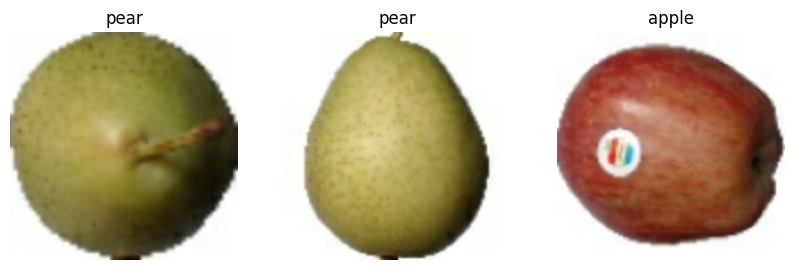

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
from tensorflow.keras import layers

num_classes = 2

model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],)

logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_images=True
)


model.fit(
    train_data,
  validation_data=val_data,
  epochs=10,
  callbacks=[tensorboard_callback]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1454/1454 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8881 - loss: 0.2634 - val_accuracy: 0.9813 - val_loss: 0.0440
Epoch 2/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9846 - loss: 0.0347 - val_accuracy: 0.9890 - val_loss: 0.0258
Epoch 3/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9937 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 2.9903e-05
Epoch 4/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 2.1437e-05 - val_accuracy: 1.0000 - val_loss: 1.1972e-05
Epoch 5/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 9.4576e-06 - val_accuracy: 1.0000 - val_loss: 5.9877e-06
Epoch 6/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 5.0747e-06 - val_accuracy: 1.0000 - val_loss: 2.8826e-06
Epoch 7/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 2.3533e-06 - val_accuracy: 1.0000 - val_loss: 1.3631e-06
Epoch 8/10
1454/1454 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 197, 197, 128)       │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 98, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 95, 95, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 16)          │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1296)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          83,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 784,664 (2.99 MB)

 Trainable params: 261,554 (1021.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 523,110 (2.00 MB)

Saving captured_image.png to captured_image (2).png


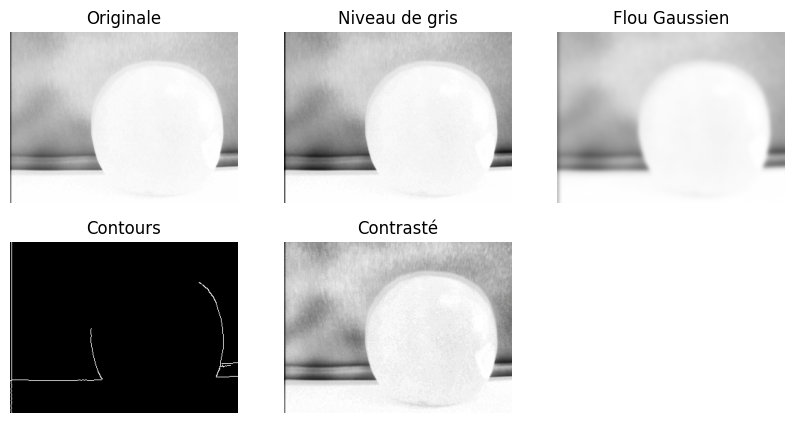

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction class: [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Probabilités (Poire, Pomme): [[1.6190727e-04 9.9983811e-01]]
C'EST UNE POMME !


In [14]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
file_to_predict = files.upload()
for file_ in file_to_predict:
    image_to_predict = cv2.imread(file_, cv2.IMREAD_COLOR)
    plt.figure(figsize=(10, 5))

    # Image originale
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.title("Originale")
    plt.axis("off")

    # Image en niveaux de gris
    gray = cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Niveau de gris")
    plt.axis("off")

    # Flou Gaussien
    blurred = cv2.GaussianBlur(image_to_predict, (15, 15), 0)
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.title("Flou Gaussien")
    plt.axis("off")

    # Détection des contours
    edges = cv2.Canny(image_to_predict, 100, 200)
    plt.subplot(2, 3, 4)
    plt.imshow(edges, cmap='gray')
    plt.title("Contours")
    plt.axis("off")

    # Image en contraste augmenté
    lab = cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Contrasté")
    plt.axis("off")

    plt.show()

    # Redimensionner pour la prédiction
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict, (200, 200)), axis=0)

    # Prédiction
    res = np.argmax(model.predict(img_to_predict), axis=-1)
    print("Prediction class:", res)
    print("Probabilités (Poire, Pomme):", model.predict(img_to_predict))

    if res == 1:
        print("C'EST UNE POMME !")
    elif res == 0:
        print("C'EST UNE POIRE !")
